# Batch Normalization
## 1. 背景知识
1. 在深层神经网络训练中，由于网络上层参数的变化而引起每层输入数据分布随之变化，这导致了训练过程变慢，这种现象叫做“Internal Covariate Shift”。
2. Internal Covariate Shift 会导致训练速度降低，因为每一层的参数$W$和$b$发生变化后，使得该层线性与非线性的计算结果的分布发生变化，后面的网络层需要去适应这种分布变化，导致整个网络的学习速度变慢。
3. 容易引起梯度消失问题，比如使用Sigmoid函数时，$z = g(Wu+b), g(x) =1/(1+exp(-x))$, 当$|x|$增大时，$g'(x)$趋向于0，导致参数更新速度变慢。
4. 文章中指出，对于激活函数饱和问题，可通过使用Relu激活函数，小心初始化和较小学习率来解决，另外，也可以让激活函数的输入分布保持在一个稳定状态来避免陷入梯度饱和区，这就引入了 Normalization。

## 2. 解决 Internal Covariate Shift
可以使用白化(Whitening)来固定网络每一层输入值的分布，加速网络训练过程的收敛。但在每一轮操作的每一层都进行白化成本太高，而且白化改变了网络每层的分布，降低了每层输入数据的表达能力。为解决这两个问题，Batch Normalization 做了简化和改进：

1. 对每个特征单独做 normalization。
2. 在每个 mini-batch 上做 normalization。
3. 同时，加上线性变换操作。

也就是说，在每个 batch 内，对某个神经元的输入数据集合做 normalization，把它们的值变换到均值为0，方差为1的分布上去。然后，对变换后的数据做线性变换，引入可变参数，$\gamma$ 和 $\beta$, $y^k = \gamma x + \beta$

## 3. Inference 阶段
Inference 阶段可能只有一个样本，该怎么使用 batch normalization 呢？

用 BN 训练模型时，我们要保留每个 batch 数据在每一层的 $\mu _{batch}$ 和 $\sigma _{batch}$，此时使用整个样本的数据来对测试数据进行 normalization：
$$\mu _{test} = E(\mu _{batch})$$
$$\sigma ^2 _{test} = {m \over {m-1}} E(\sigma ^2 _{batch})$$
$$BN(X_{test}) = \gamma \cdot {X_{test}-\mu_{test}\over{\sqrt{\sigma^2_{test} + \epsilon}}} + \beta$$

## 4. Batch Normalization 的好处
1. 使得每一层数据的分布相对稳定，加速神经网络的学习。
2. 可以使用较大的学习率，对初始参数也不敏感。
3. 对 Sigmoid 激活函数可解决梯度消失问题。
4. 可以不用 dropout 了。

## 5. Tensorflow 实现总结
1. 较为低级的接口为:
        tf.nn.batch_normalization(x, mean, variance, offset, scale, variance_epsilon, name=None)
需要手动计算并添加 mean, variance 等参数，比较麻烦。
2. 推荐使用高级接口：

        tf.layers.batch_normalization(inputs, trainning=True/False)
该接口参数很多，一般只需要填写 inputs 和 training，训练阶段 training 设为True，inference 阶段设为 False。最后一层不需要做 BN。
3. 训练时需要加 control_dependencies，比如：

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):          
             train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

这样是为了能计算 $\mu$ 和 $\sigma$ 的滑动平均值。

## Reference

* https://github.com/NELSONZHAO/zhihu

* https://r2rt.com/implementing-batch-normalization-in-tensorflow.html

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


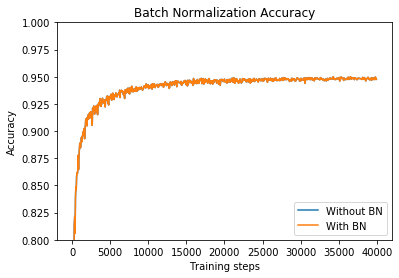

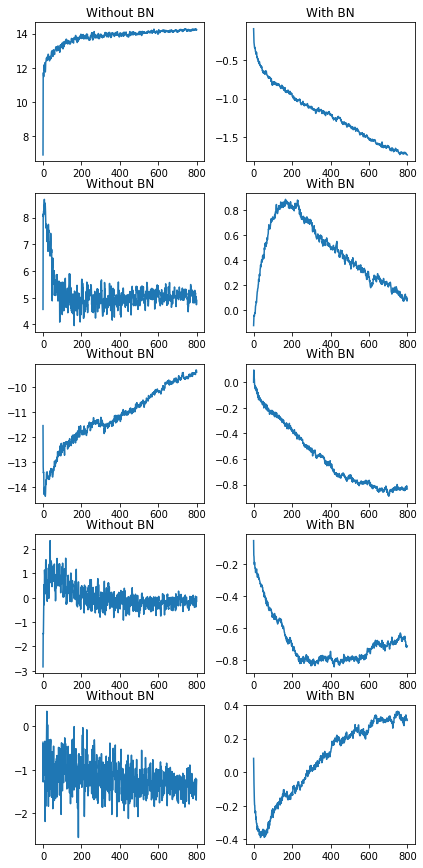

In [26]:
import numpy as np, tensorflow as tf
from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

w1_initial = np.random.normal(size=(784, 100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x, w1) + b1
l1 = tf.nn.sigmoid(z1)

# Layer 1 with BN
w1_BN = tf.Variable(w1_initial)
z1_BN = tf.matmul(x, w1_BN)

# Calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_BN, [0])

# Apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

# Layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1, w2) + b2
l2 = tf.nn.sigmoid(z2)

# Layer 2 with BN, using Tensorflows built-in BN function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN, w2_BN)
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN, batch_mean2, batch_var2, beta2, scale2, epsilon)
l2_BN = tf.nn.sigmoid(BN2)

# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(l2,w3)+b3)

w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN = tf.nn.softmax(tf.matmul(l2_BN, w3_BN) + b3_BN)

# Loss, optimizer and predictions
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_ * tf.log(y_BN))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
correct_prediction_BN = tf.equal(tf.argmax(y_BN, 1), tf.argmax(y_, 1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

zs, BNs, acc, acc_BN = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(40000):
    batch = mnist.train.next_batch(60)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    
    if i % 50 is 0:
        res = sess.run([accuracy,accuracy_BN,z2,BN2],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        acc.append(res[0])
        acc_BN.append(res[1])
        zs.append(np.mean(res[2], axis=0)) # record the mean value of z2 over the entire test set
        BNs.append(np.mean(res[3], axis=0)) # record the mean value of BN2 over the entire test set
        
zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

fig, ax = plt.subplots()

ax.plot(range(0,len(acc)*50,50),acc, label='Without BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])

In [3]:
import numpy as np
import tensorflow as tf

w = np.arange(6).reshape(2, 3)
w1 = tf.Variable(w, dtype=tf.float32)
mean, var = tf.nn.moments(w1, [0])
w1_hat = (w1 - mean) / tf.sqrt(var)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print(sess.run(w1))
    print(sess.run([mean, var]))
    print(sess.run(w1_hat))

[[0. 1. 2.]
 [3. 4. 5.]]
[array([1.5, 2.5, 3.5], dtype=float32), array([2.25, 2.25, 2.25], dtype=float32)]
[[-1. -1. -1.]
 [ 1.  1.  1.]]


In [13]:
import tensorflow as tf

correct_prediction = tf.equal(1, 1)
test = tf.cast(correct_prediction, tf.float32)
sess = tf.InteractiveSession()
print(sess.run(test))

1.0


In [43]:
import numpy as np, tensorflow as tf, tqdm
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

w1_initial = np.random.normal(size=(784, 100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

def batch_norm_wrapper(inputs, is_training, decay=0.999):
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)
    
    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, epsilon)
    
def build_graph(is_training):
    # Placeholders
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # Layer 1
    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x, w1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)
    
    # Layer 2
    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1, w2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.sigmoid(bn2)
    
    # Softmax
    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y = tf.nn.softmax(tf.matmul(l2, w3))
    
    # Loss, Optimizer and Predictions
    cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
    
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

    return (x, y_), train_step, accuracy, y, tf.train.Saver()

sess.close()
tf.reset_default_graph()
(x, y_), train_step, accuracy, _, saver = build_graph(is_training=True)

acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 50 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc.append(res[0])
    saved_model = saver.save(sess, './temp-bn-save')

print("Final accuracy:", acc[-1])

tf.reset_default_graph()
(x, y_), _, accuracy, y, saver = build_graph(is_training=False)

predictions = []
correct = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './temp-bn-save')
    for i in range(100):
        pred, corr = sess.run([tf.arg_max(y,1), accuracy],
                             feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
        correct += corr
        predictions.append(pred[0])

print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./temp-bn-save
PREDICTIONS: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 7, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
ACCURACY: 0.98


1.6.0
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
【Training Result:】

Without Batch_Norm: The final accuracy on validation data is 0.9764000177383423
With Batch Norm: The final accuracy on validation data is 0.9814000129699707

【Testing Result:】

Without Batch_Norm: The final accuracy on test data is 0.9742000102996826
With Batch Norm: The final accuracy on test data is 0.9803000092506409


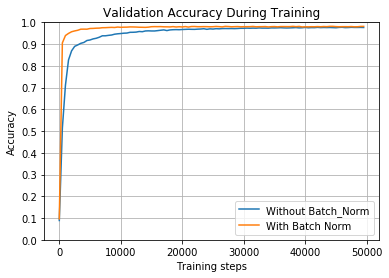

In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

print(tf.__version__)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

class NeuralNetWork():
    def __init__(self, initial_weights, activation_fn, use_batch_norm):
        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch_Norm"
        
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        
        self.training_accuracies = []
        self.build_network(initial_weights, activation_fn)
        
    def build_network(self, initial_weights, activation_fn):
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        
        for layer_weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, layer_weights, activation_fn)
        
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
        
    def fully_connected(self, layer_in, layer_weights, activation_fn=None):
        if self.use_batch_norm and activation_fn:
            weights = tf.Variable(layer_weights)
            linear_output = tf.matmul(layer_in, weights)
            
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
            return activation_fn(batch_normalized_output)
        else:
            weights = tf.Variable(layer_weights)
            bias = tf.Variable(tf.zeros([layer_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), bias)

            return activation_fn(linear_output) if activation_fn else linear_output
        
    def train(self, sess, learning_rate, training_batches, batches_per_validate_data, save_model=None):
        # 定义输出label
        labels = tf.placeholder(tf.float32, [None, 10])
        
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, 
                                                                                  logits=self.output_layer))
        # 准确率
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        if self.use_batch_norm:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

        for i in range(training_batches):
            batch_x, batch_y = mnist.train.next_batch(60)
            sess.run(train_step, feed_dict={self.input_layer: batch_x,
                                            labels: batch_y,
                                            self.is_training: True})
            if i % batches_per_validate_data == 0:
                val_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                              labels: mnist.validation.labels,
                                                              self.is_training: False})
                self.training_accuracies.append(val_accuracy)
        print("{}: The final accuracy on validation data is {}".format(self.name, val_accuracy))
        
        if save_model:
            tf.train.Saver().save(sess, save_model)
        
    def test(self, sess, test_training_accuracy=False, restore=None):
        # 定义label
        labels = tf.placeholder(tf.float32, [None, 10])
        
        # 准确率
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # 是否加载模型
        if restore:
            tf.train.Saver().restore(sess, restore)
        
        test_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                      labels: mnist.test.labels,
                                                      self.is_training: False})
        
        print("{}: The final accuracy on test data is {}".format(self.name, test_accuracy))
        

def plot_training_accuracies(*args, batches_per_validate_data):
    """
    绘制模型在训练过程中的准确率曲线
    
    :param args: 一个或多个NeuralNetWork对象
    :param batches_per_validate_data: 训练多少个batch进行一次数据验证
    """
    fig, ax = plt.subplots()
    
    for nn in args:
        ax.plot(range(0, len(nn.training_accuracies)*batches_per_validate_data, batches_per_validate_data),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

def train_and_test(use_larger_weights, learning_rate, activation_fn, training_batches=50000, batches_per_validate_data=500):
    """
    使用相同的权重初始化生成两个网络对象，其中一个使用BN，另一个不使用BN
    
    :param use_larger_weights: 是否使用更大的权重
    :param learning_rate: 学习率
    :param activation_fn: 激活函数
    :param training_batches: 训练阶段使用的batch数（默认为50000）
    :param batches_per_validate_data: 训练多少个batch后在validation数据上进行测试
    """
    if use_larger_weights:
        weights = [np.random.normal(size=(784,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,10), scale=10.0).astype(np.float32)
                  ]
    else:
        weights = [np.random.normal(size=(784,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,10), scale=0.05).astype(np.float32)
                  ]

    tf.reset_default_graph()

    nn = NeuralNetWork(weights, activation_fn, use_batch_norm=False) # Without BN
    bn = NeuralNetWork(weights, activation_fn, use_batch_norm=True) # With BN
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        print("【Training Result:】\n")
        
        nn.train(sess, learning_rate, training_batches, batches_per_validate_data)
        bn.train(sess, learning_rate, training_batches, batches_per_validate_data)
        
        print("\n【Testing Result:】\n")
        nn.test(sess)
        bn.test(sess)
    
    plot_training_accuracies(nn, bn, batches_per_validate_data=batches_per_validate_data)


train_and_test(use_larger_weights=False, learning_rate=0.01, activation_fn=tf.nn.relu)